In [1]:
# ### mount on google drive
# from google.colab import drive
# drive.mount('/content/drive/')
# import os
# os.chdir("/content/drive/My Drive/WatNet/notebooks")
# # !pip install rasterio

In [1]:
import os
os.chdir('..')
import time
import random
import numpy as np
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from dataloader.tfrecord_io import parse_image,parse_shape,toPatchPair
from notebooks import config
from utils.acc_eval import acc_patch
from utils.imgShow import imgShow, imsShow
from dataloader.loader import get_scene, get_patch, image_aug
from models.seg_model.watnet import watnet


In [3]:
## get training data
### data loading from file path
paths_tra_scene = sorted(glob.glob(config.root+'/data/dataset-s2/tra_scene/*'))
paths_tra_truth = sorted(glob.glob(config.root+'/data/dataset-s2/tra_truth/*'))


In [16]:
from utils.tiff_io import readTiff
patches_pair = []
paths_scene_pair = zip(paths_tra_scene,paths_tra_truth)
for scene_path, truth_path in paths_scene_pair:
    _, scene = readTiff(scene_path)
    _, truth = readTiff(truth_path)
    patches_pair.append((scene,truth))



2

In [6]:
def crop2patch(img, width, height):
    assert img.shape[0] >= height
    assert img.shape[1] >= width
    x_start = random.randint(0, img.shape[1]-width)
    y_start = random.randint(0, img.shape[1]-height)



64

### Load and parse the tfrecord data

In [4]:
### data loading from .tfrecord file
path_tra_data = 'data/tfrecord-s2/tra_data.tfrecords'
path_val_data = 'data/tfrecord-s2/val_data.tfrecords'
## training data
traData = tf.data.TFRecordDataset(path_tra_data)
traData = traData.map(parse_image).map(parse_shape)\
            .cache()\
            .map(toPatchPair)\
            .map(image_aug)
traData = traData.shuffle(config.buffer_size).batch(config.batch_size)

## validation data
valData = tf.data.TFRecordDataset(path_val_data)
valData = valData.map(parse_image).map(parse_shape)\
            .map(toPatchPair)\
            .cache()
valData = valData.batch(config.batch_size)
traData
valData


<BatchDataset shapes: ((None, 512, 512, 6), (None, 512, 512, 1)), types: (tf.float32, tf.float32)>

In [5]:
# for i in range(5):
#     start = time.time()
#     i = 1
#     for tra_patch, tra_truth in traData:
#         i+=1
#     imgShow(tra_truth.numpy()[0])
#     plt.show()
#     print('num:', i)
#     print('time:', time.time()-start)


In [6]:
## model configuration
model = watnet(input_shape=(config.patch_size, config.patch_size, 6), nclasses=2)



*** Building DeepLabv3Plus Network ***
*** Output_Shape => (None, 512, 512, 1) ***


In [7]:
'''------1. train step------'''
@tf.function
def train_step(model, loss_fun, optimizer, x, y):
    with tf.GradientTape() as tape:
        y_pre = model(x, training=True)
        loss = loss_fun(y, y_pre)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    config.tra_loss.update_state(loss)
    config.tra_oa.update_state(y, y_pre)
    config.tra_miou.update_state(y, y_pre)
    return config.tra_loss.result(), config.tra_oa.result(), config.tra_miou.result()

'''------2. test step------'''
@tf.function
def test_step(model, loss_fun, x, y):
    with tf.GradientTape() as tape:
        y_pre = model(x, training=False)
        loss = loss_fun(y, y_pre)
    config.val_loss.update_state(loss) 
    config.val_oa.update_state(y, y_pre)
    config.val_miou.update_state(y, y_pre)
    return config.val_loss.result(), config.val_oa.result(), config.val_miou.result()

'''------3. train loops------'''
def train_loops(model, loss_fun, optimizer, tra_dset, val_dset, epochs):
    max_miou_pre = 0.8
    for epoch in range(epochs):
        start = time.time()
        '''---3.1 train the model---'''
        for x_batch, y_batch in tra_dset:
            tra_loss_epoch,tra_oa_epoch,tra_miou_epoch = train_step(model, loss_fun, optimizer, x_batch, y_batch)        
        '''---3.2 test the model---'''
        for x_batch, y_batch in val_dset:
            val_loss_epoch, val_oa_epoch, val_miou_epoch = test_step(model, loss_fun, x_batch, y_batch)
        '''---3.3 update the metrics----'''
        config.tra_loss.reset_states(), config.tra_oa.reset_states(), config.tra_miou.reset_states()
        config.val_loss.reset_states(), config.val_oa.reset_states(), config.val_miou.reset_states()
        format = 'Ep {}: traLoss:{:.3f},traOA:{:.2f},traMIoU:{:.2f},valLoss:{:.3f},traOA:{:.2f},traMIoU:{:.2f},time:{:.0f}s'
        print(format.format(epoch + 1, tra_loss_epoch, tra_oa_epoch, tra_miou_epoch, val_loss_epoch, val_oa_epoch, val_miou_epoch, time.time() - start))

        '''---3.4 visualize the results---'''
        if epoch%20 == 0:
            i = np.random.randint(config.batch_size)
            for val_patch, val_truth in val_dset.take(1):
                plt.figure(figsize=(8,4))
                imsShow(img_list=[val_patch.numpy()[i], val_truth.numpy()[i]], \
                        img_name_list=['val_patch', 'val_truth'], \
                        clip_list=[2,0],\
                        color_bands_list=None)
                plt.show()


Ep 1: traLoss:0.358,traOA:0.87,traMIoU:0.69,valLoss:1.716,traOA:0.78,traMIoU:0.39,time:13s


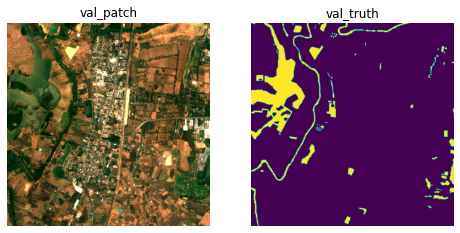

Ep 2: traLoss:0.187,traOA:0.93,traMIoU:0.84,valLoss:1.395,traOA:0.64,traMIoU:0.38,time:5s
Ep 3: traLoss:0.160,traOA:0.94,traMIoU:0.87,valLoss:0.780,traOA:0.78,traMIoU:0.39,time:5s


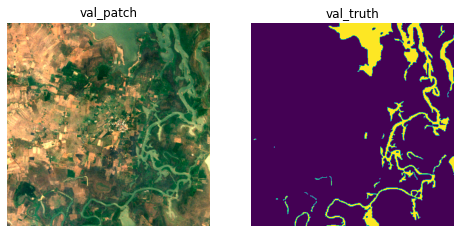

Ep 4: traLoss:0.167,traOA:0.93,traMIoU:0.83,valLoss:0.881,traOA:0.78,traMIoU:0.39,time:5s
Ep 5: traLoss:0.121,traOA:0.96,traMIoU:0.89,valLoss:0.699,traOA:0.78,traMIoU:0.39,time:5s


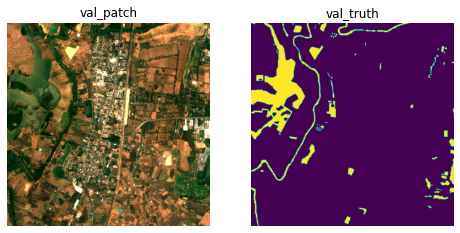

Ep 6: traLoss:0.142,traOA:0.94,traMIoU:0.85,valLoss:0.839,traOA:0.78,traMIoU:0.39,time:5s
Ep 7: traLoss:0.154,traOA:0.93,traMIoU:0.83,valLoss:0.851,traOA:0.78,traMIoU:0.39,time:5s


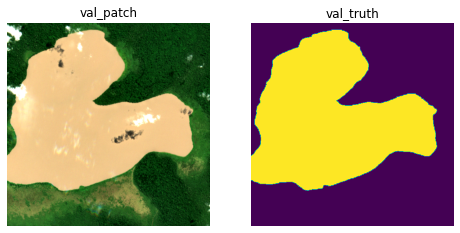

Ep 8: traLoss:0.200,traOA:0.93,traMIoU:0.84,valLoss:0.475,traOA:0.78,traMIoU:0.39,time:5s
Ep 9: traLoss:0.187,traOA:0.93,traMIoU:0.84,valLoss:2.635,traOA:0.78,traMIoU:0.39,time:5s


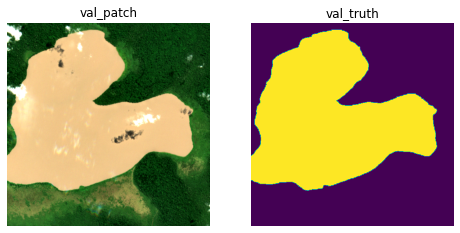

Ep 10: traLoss:0.162,traOA:0.94,traMIoU:0.86,valLoss:0.432,traOA:0.77,traMIoU:0.39,time:5s


In [8]:
## training
train_loops(model=model, \
            loss_fun=config.loss_bce, \
            optimizer=config.opt_adam, \
            tra_dset=traData, \
            val_dset=valData, \
            epochs=config.epochs)


In [10]:
### model saving
# path_save = 'models/pretrained_model/watnet_tmp'
# model.save(path_save)

